In [8]:

#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/CNN_assignment (1).zip" > /dev/null

In [10]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img


In [11]:

# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [12]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)


2239
118


In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:

#Train datset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
#Validation Dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:

#All the classes of skin cancer.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


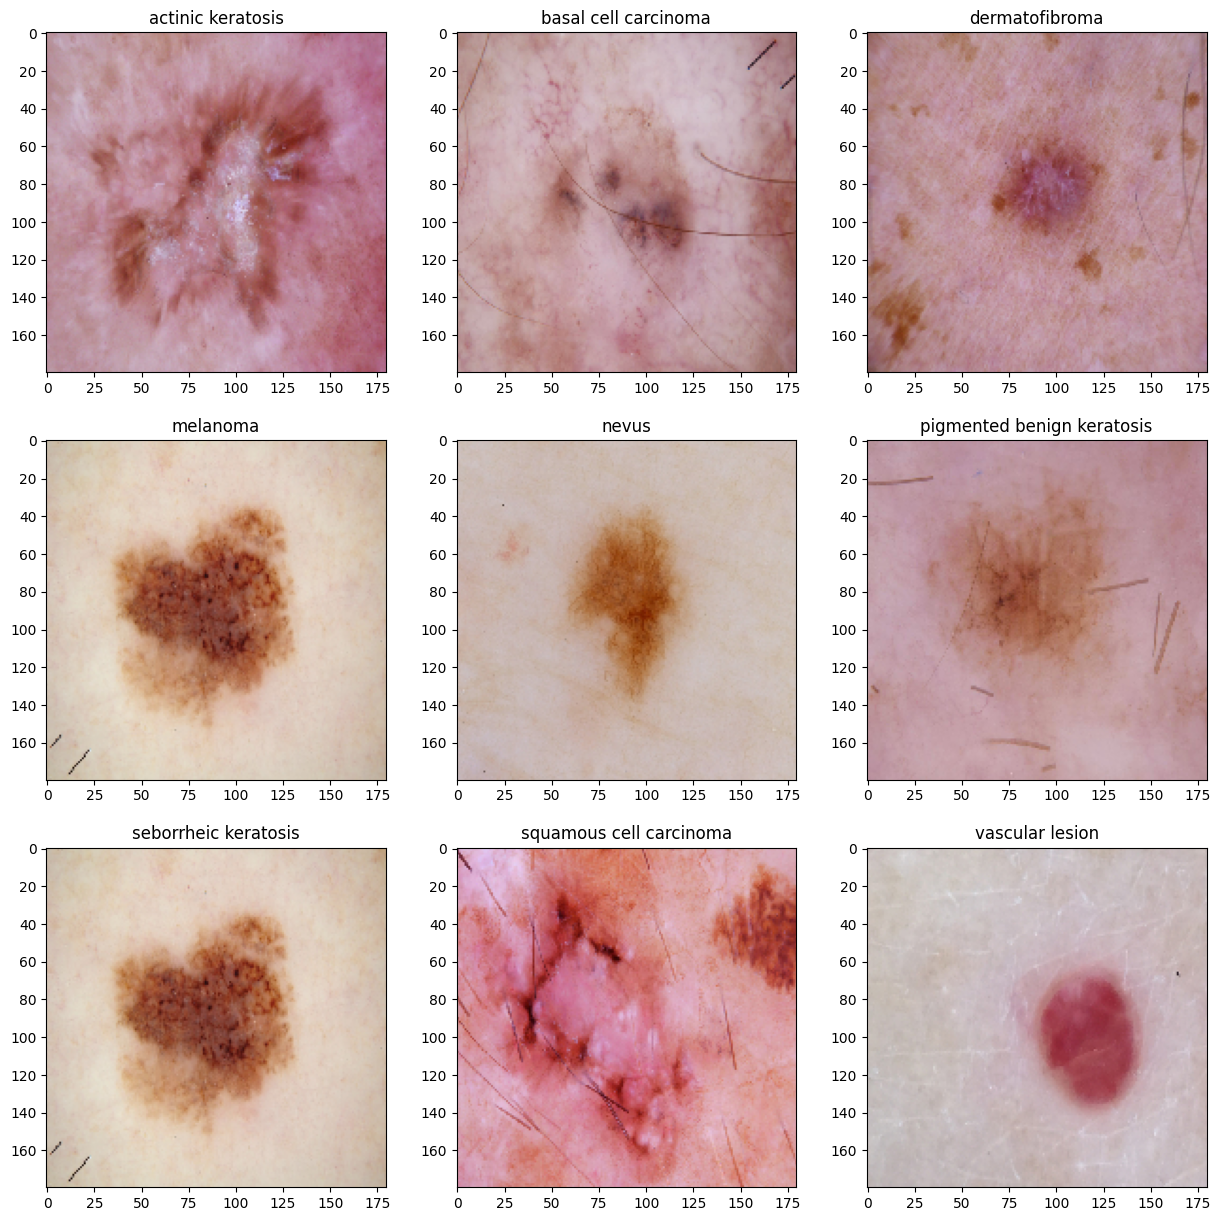

In [17]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)


In [18]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


input_shape = (img_height,img_width,3)

model = Sequential()    #Sequential allows you to create models layer-by-layer

#First Convulation Layer
# Rescaling is no longer in experimental in newer Keras versions
model.add(layers.Rescaling(1./255, input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [21]:

# summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,374,985 (100.61 MB)

 Trainable params: 26,374,985 (100.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.1920 - loss: 2.6409 - val_accuracy: 0.2931 - val_loss: 1.8823
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.3161 - loss: 1.8416 - val_accuracy: 0.4519 - val_loss: 1.5846
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.4342 - loss: 1.6005 - val_accuracy: 0.4206 - val_loss: 1.6244
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.4480 - loss: 1.5301 - val_accuracy: 0.4810 - val_loss: 1.5208
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.5627 - loss: 1.2884 - val_accuracy: 0.5190 - val_loss: 1.3951
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.5665 - loss: 1.2723 - val_accuracy: 0.5347 - val_loss: 1.4409
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.5529 - loss: 1.1985 - val_accuracy: 0.5280 - val_loss: 1.5304
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.5640 - loss: 1.2198 - val_accuracy: 0.4877 - v

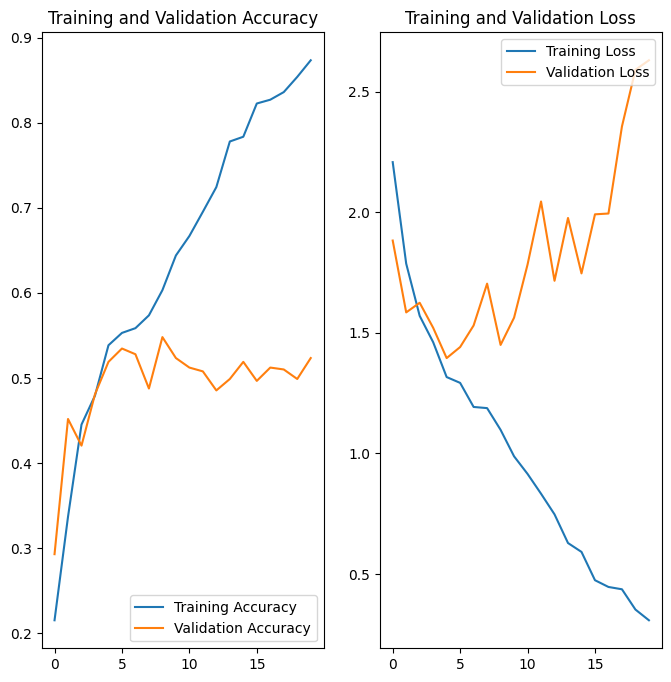

In [23]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range
  # The 'experimental' namespace is removed in newer versions
  # directly use preprocessing layers from tf.keras.layers.preprocessing
  layers.Rescaling(1./255)  # Removed preprocessing and call layers.Rescaling directly
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.RandomFlip("horizontal_and_vertical"), # Removed preprocessing and call layers.RandomFlip directly

  #Randomly rotate each image.
  layers.RandomRotation(0.2), # Removed preprocessing and call layers.RandomRotation directly

  #Randomly zoom each image during training.
  layers.RandomZoom(0.2), # Removed preprocessing and call layers.RandomZoom directly

  #Randomly translate each image during training.
  layers.RandomTranslation(0.1, 0.1)  # Removed preprocessing and call layers.RandomTranslation directly
])


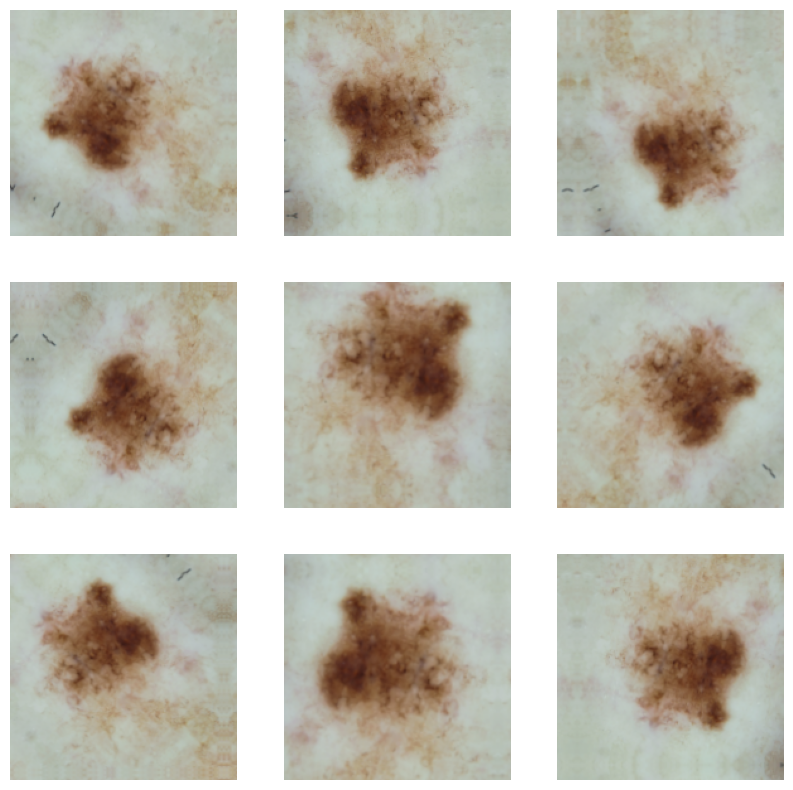

In [25]:

#Visualize the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [26]:
## Model 2 Creation

#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.


## Your code goes here
model2 = Sequential()                     #Sequential allows you to create models layer-by-layer

model2.add(data_augmentation)             #Augmentation layer
model2.add(rescale)                       #Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

In [27]:

model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [29]:


epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.4011 - loss: 1.6664 - val_accuracy: 0.4676 - val_loss: 1.5765
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.4271 - loss: 1.6101 - val_accuracy: 0.4676 - val_loss: 1.5386
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.4939 - loss: 1.4871 - val_accuracy: 0.4541 - val_loss: 1.5705
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 207s 3s/step - accuracy: 0.4875 - loss: 1.4697 - val_accuracy: 0.4743 - val_loss: 1.5149
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.4905 - loss: 1.4765 - val_accuracy: 0.3714 - val_loss: 1.7340
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.4478 - loss: 1.5760 - val_accuracy: 0.5056 - val_loss: 1.4589
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.4986 - loss: 1.4286 - val_accuracy: 0.4877 - val_loss: 1.5078
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.4934 - loss: 1.4514 - val_accuracy: 0.4922 - v

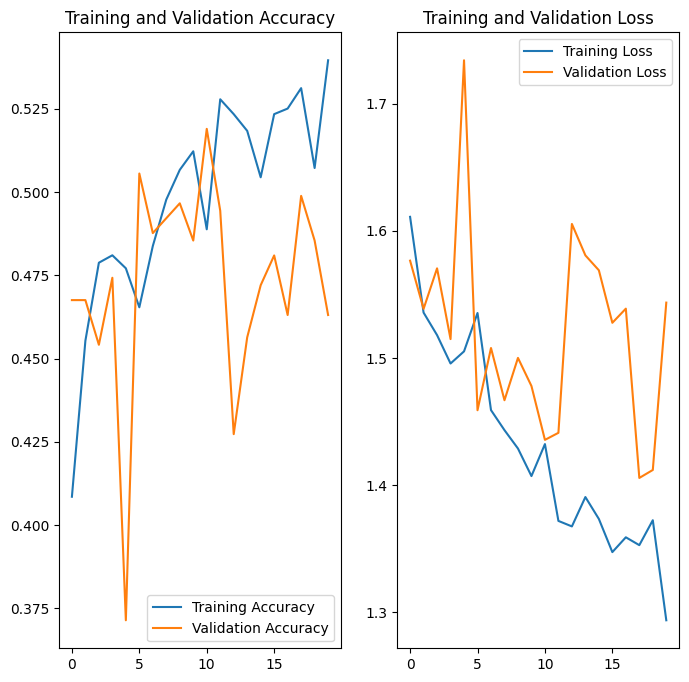

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,dermatofibroma,95
1,melanoma,438
2,vascular lesion,139
3,nevus,357
4,basal cell carcinoma,376
5,actinic keratosis,114
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,squamous cell carcinoma,181


<Axes: xlabel='No. of Image', ylabel='Class'>

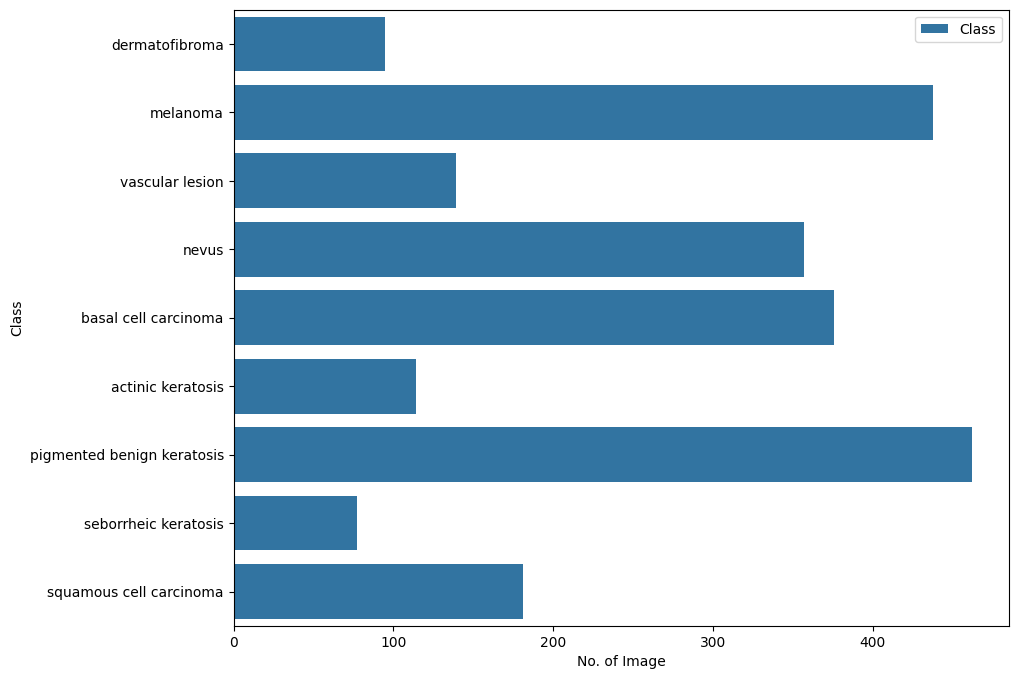

In [32]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [33]:

!pip install Augmentor

In [46]:

path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79F387FD6230>: 100%|██████████| 500/500 [00:18<00:00, 26.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79F360D8BCD0>: 100%|██████████| 500/500 [00:17<00:00, 28.07 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79F367A26B00>: 100%|██████████| 500/500 [00:20<00:00, 23.87 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79F367A364D0>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x79F35B382D10>: 100%|██████████| 500/500 [01:34<00:00,  5.30 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79F360FDEAA0>: 100%|██████████| 500/500 [00:20<00:00, 24.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x79F360CC5A50>: 100%|██████████| 500/500 [00:38<00:00, 12.90 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79F35B37BB20>: 100%|██████████| 500/500 [00:18<00:00, 26.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79F3677F1930>: 100%|██████████| 500/500 [00:18<00:00, 26.85 Samples/s]


In [35]:

#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [36]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list


In [37]:

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [38]:


dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [39]:


#dataframe that store path and label of the images generated by Augmentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [40]:

#label count.
df2['Label'].value_counts()

,count
Label,
dermatofibroma,500
melanoma,500
vascular lesion,500
nevus,500
basal cell carcinoma,500
actinic keratosis,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500


In [41]:

batch_size = 32
img_height = 180
img_width = 180

In [42]:

data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [43]:
#Validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',   #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [44]:

#Model

model3 = Sequential()

model3.add(rescale)   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

In [47]:

model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
epochs = 50
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 429s 3s/step - accuracy: 0.1388 - loss: 2.6834 - val_accuracy: 0.1203 - val_loss: 3.5254
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.2492 - loss: 2.0428 - val_accuracy: 0.1403 - val_loss: 3.6913
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 418s 2s/step - accuracy: 0.3404 - loss: 1.7586 - val_accuracy: 0.1915 - val_loss: 2.7113
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.4029 - loss: 1.5714 - val_accuracy: 0.2821 - val_loss: 2.3259
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.4089 - loss: 1.5291 - val_accuracy: 0.4343 - val_loss: 1.4761
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 413s 2s/step - accuracy: 0.4373 - loss: 1.4920 - val_accuracy: 0.2324 - val_loss: 2.7970
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 412s 2s/step - accuracy: 0.4584 - loss: 1.4219 - val_accuracy: 0.2279 - val_loss: 2.9215
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.4724 - loss: 1.3908 - val_accu

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()